# ICLR Analysis -- GLM



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, absolute_import, division
import sys, os, json, time, datetime, logging, multiprocessing, itertools
import re, ast, io, logging, tqdm, spacy
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [50]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
# sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42,
                        'image.interpolation':'nearest', 'figure.figsize': (10,8),
                     'text.usetex': False
                     
                    })
tqdm.tqdm.pandas()
logging.getLogger().setLevel(logging.CRITICAL)

In [4]:
DATA_PATH = Path('PATH_TO_DB')
DB_NAME = "cs_conf_release.db"
db_con = sqlite3.connect(DATA_PATH/DB_NAME)
backup_db_con = None
filedb_con = None


In [5]:
import src.utils as utils
import src.data_utils as data_utils

### Load Data

In [91]:
dataloader = data_utils.DataLoader(db_con, filedb_con)

In [ ]:
author_grp = dataloader.get_table('author_grp')

In [526]:
author_grp = dataloader.get_table('author_grp')
author_full = dataloader.get_table('author_full')
sub_reviews = dataloader.get_table('sub_reviews')
sub_reviews_agg = dataloader.get_table('sub_reviews_agg')
sub_derive = dataloader.get_table('sub_derive')

In [527]:
design_dat = (sub_reviews_agg
 .merge(sub_derive,on='submission_id',how='inner')
 .merge(author_grp,on='submission_id',how='inner')
 .drop(['year_x','year_y','arxiv_first_y'],axis=1).rename({'arxiv_first_x':'arxiv_first'},axis=1)
  
)

design_dat=design_dat.merge( 
    (pd.DataFrame(design_dat.groupby('primary_keyword').submission_id.nunique().sort_values(ascending=False))
     .reset_index().rename({'submission_id':'primary_kwd_cnt'}, axis=1)
    ), on='primary_keyword', how='left',
)


# design_dat.conf_year=design_dat.conf_year.astype(int)
design_dat=utils.df_col_totype(design_dat,['sub_fluency','n_fig', 'n_ref','n_sec'],float)

In [528]:
vec_embds = pd.read_csv(DATA_PATH/"submission_specter_embedding.csv")
utils.lit_eval_df(vec_embds, ['encoded_vec'])

In [529]:
vec_embds['vec'] = vec_embds.encoded_vec.apply(
    lambda x : np.array(x)/np.linalg.norm(x))

vec_embds= vec_embds.rename({'id':'submission_id'},axis=1)
vec_embds=pd.concat([vec_embds,
           pd.DataFrame(vec_embds.vec.tolist(), columns=[f'vec_{i}' for i in range(1,769)])
          ], axis=1)

### Table One

In [19]:
import tableone
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
t0df=tableone.TableOne((design_dat
                        .drop(['secondary_keyword','primary_keyword','binary_decision','demo_mode'
                              ],axis=1)
                        .set_index('submission_id')
                       ),
                          categorical=['decision','arxiv_first','any_reported_f','any_perceived_f','demo_no_us'],
                       groupby=['year'],
                       pval=True
)

In [22]:
sub_reviews['review_type'] =\
    sub_reviews['rating_int'].apply(lambda s : 'Positive' if s > 7 else ('Negative' if s < 5 else 'Borderline'))

In [24]:
t1df=tableone.TableOne(sub_reviews.drop(['id', 'submission_id', 'n_review',
                                              'review_id','input_len','decision','binary_decision'],axis=1),#.set_index('submission_id'),
                          categorical=['review_type'],
                       groupby=['year'],
                       pval=True,
)

In [28]:
t2df=tableone.TableOne(author_full.drop_duplicates(['author_id','year']).drop(['iso_a3',
                    'full_decision', 'tld',
                    'author_id','submission_id','n_author','ins_root'],axis=1),#.set_index(['author_id','year']),
                          categorical=['country','reported_gender','decision'],
                       groupby=['year'],
                       pval=True
)

In [29]:
t2df

Grouped by year                                                                                                                                      
                                                            Missing           Overall              2017              2018              2019              2020              2021              2022 P-Value
n                                                                               31780              1416              2703              4286              6807              7914              8654        
author_no, mean (SD)                                              0         2.9 (2.0)         2.6 (1.7)         2.7 (1.8)         2.7 (1.8)         2.8 (1.9)         2.9 (2.0)         3.1 (2.4)  <0.001
reported_gender, n (%)           Female                           0        2470 (7.8)          81 (5.7)         162 (6.0)         298 (7.0)         503 (7.4)         656 (8.3)         770 (8.9)  <0.001
                                 Male                                    19099 (60.1)        769 (54.3)       1565 (57.9)       2527 (59.0)       3951 (58.0)       4763 (60.2)       5524 (63.8)        
                                 Non-Binary                                  18 (0.1)           1 (0.1)           2 (0.1)           2 (0.0)           2 (0.0)           5 (0.1)           6 (0.1)        
                                 Unspecified                             10193 (32.1)        565 (39.9)        974 (36.0)       1459 (34.0)       2351 (34.5)       2490 (31.5)       2354 (27.2)        
perceived_gender, mean (SD)                                   10077         0.9 (0.3)         0.9 (0.3)         0.9 (0.3)         0.9 (0.3)         0.9 (0.3)         0.9 (0.3)         0.9 (0.3)  <0.001
decision, n (%)                  Accept                        7717      11142 (46.3)        484 (57.7)        943 (52.2)       1441 (46.9)       2032 (41.4)       2658 (43.5)       3584 (48.9)  <0.001
                                 Reject                                  12921 (53.7)        355 (42.3)        862 (47.8)       1632 (53.1)       2881 (58.6)       3451 (56.5)       3740 (51.1)        
country, n (%)                   Australia                     9998         318 (1.5)                            18 (1.1)          42 (1.5)          72 (1.6)          93 (1.7)          93 (1.4)  <0.001
                                 Austria                                     72 (0.3)           6 (0.8)          10 (0.6)           4 (0.1)           8 (0.2)          23 (0.4)          21 (0.3)        
                                 Bangladesh                                   1 (0.0)                                                                                   1 (0.0)                          
                                 Belgium                                      9 (0.0)                             1 (0.1)           3 (0.1)                                               5 (0.1)        
                                 Brazil                                       2 (0.0)                             1 (0.1)                                                                 1 (0.0)        
                                 Canada                                    1111 (5.1)          55 (6.9)         111 (6.6)         167 (5.9)         215 (4.8)         258 (4.7)         305 (4.7)        
                                 Chile                                        7 (0.0)                                               1 (0.0)           5 (0.1)                             1 (0.0)        
                                 China                                    2443 (11.2)          10 (1.3)          75 (4.5)         196 (6.9)        479 (10.8)        655 (11.8)       1028 (15.8)        
                                 Czech Republic                              13 (0.1)                                               4 (0.1)           1 (0.0)           6 (0.1)           2 (0.0)        
            

In [717]:
print(t1df.to_latex())

\begin{tabular}{lllllllllll}
\toprule
                   &          & \multicolumn{9}{l}{Grouped by year} \\
                   &          &         Missing &        Overall &           2017 &           2018 &           2019 &           2020 &           2021 &           2022 & P-Value \\
\midrule
n & {} &                 &          35717 &           1489 &           2748 &           4332 &           6721 &          10026 &          10401 &         \\
rating\_int, mean (SD) &          &               0 &      5.3 (1.8) &      5.7 (1.6) &      5.4 (1.5) &      5.4 (1.5) &      4.4 (2.2) &      5.5 (1.4) &      5.5 (1.7) &  <0.001 \\
confidence\_int, mean (SD) &          &               0 &      3.6 (0.9) &      3.8 (0.8) &      3.8 (0.8) &      3.8 (0.8) &      3.1 (1.3) &      3.7 (0.8) &      3.7 (0.8) &  <0.001 \\
sentiment, mean (SD) &          &               1 &      0.6 (0.1) &      0.6 (0.2) &      0.6 (0.2) &      0.6 (0.1) &      0.6 (0.1) &      0.6 (0.1) &      0.6 (0.1) &  <

## Scoring Level Models

## Decision Level Models

with access to review information such as rating / confidence / sentiment etc

#### What explains decision of borderline papers?

In [31]:
import sklearn
import sklearn.metrics
import sklearn.metrics as skm
import statsmodels.formula.api as smf
import mapie


In [530]:
sub_full_rev = sub_full.merge(sub_rev_agg, ).merge(sub_derive)

In [165]:
design_dat.to_csv("./design_mat.csv", index=False, header=True)

In [411]:
import sklearn
import sklearn.cluster
import sklearn.manifold

In [531]:
Xvec = np.vstack(vec_embds['vec'].values)
Xcls = sklearn.cluster.SpectralClustering(n_clusters=20,
    assign_labels='discretize',).fit(Xvec)
Yvec = Xcls.labels_
vec_embds['cluster'] = Yvec

In [763]:
reg_data = (design_dat[~design_dat.isna().any(axis=1)]
#             .query("rating_avg.between(5,6.75)")
            .reset_index(drop=True)
           ).merge(vec_embds,on='submission_id')
reg_data['ins_rank_max_lg'] = reg_data['ins_rank_max'].apply(np.log)
reg_data['ins_rank_avg_lg'] = reg_data['ins_rank_avg'].apply(np.log)
reg_data['author_cite_max_lg'] = reg_data['author_cite_max'].apply(np.log)
reg_data['author_cite_avg_lg'] = reg_data['author_cite_avg'].apply(np.log)

## prediction
reg_data_tr = reg_data.sample(int(reg_data.shape[0] * 0.8)).reset_index(drop=True)
reg_data_val = reg_data[~reg_data.submission_id.isin(reg_data_tr.submission_id.unique())].reset_index(drop=True)


## forecasting

reg_data_tr = reg_data.query('year<2022').reset_index(drop=True)
reg_data_val = reg_data.query('year==2022').reset_index(drop=True)

In [787]:
formula_comp = {
    'year': '0',
    'sub': 'np.log(input_len) + n_fig + n_ref + n_sec',
    'sub_nlp' : 'sub_fluency + C(cluster) ', # + '+' + ' + '.join([f'vec_{i}' for i in range(1,769)]),
    'arxiv': 'arxiv_first',
    'review': 'n_review + rating_max + rating_min + rating_avg + confidence_avg + confidence_max + confidence_min',
    'review_nlp': 'rlen_avg + rlen_min + rlen_max  + sentiment_avg + sentiment_min + sentiment_max',
    'inst': 'np.log(ins_rank_max) +np.log(ins_rank_avg)',
#     'author': 'np.log(author_cite_max) + np.log(author_cite_avg) + n_author',
    'author': 'n_author',
    'author_gender': ' any_reported_f + cnt_reported_f + any_perceived_f + cnt_perceived_f',
    'author_cite': 'np.log(author_cite_max) + np.log(author_cite_avg)',
    'geo': 'C(demo_no_us)',
    'topic': 'np.log(primary_kwd_cnt)'
}

In [788]:
formulas = {
    'base': ['year', 'sub', 'sub_nlp', 'arxiv', 'topic'],
    '+author': ['year', 'sub', 'sub_nlp', 'arxiv', 'topic']+['author','author_gender','inst','author_cite'],    
    '+rev': ['year','sub','sub_nlp'] + ['review'] ,
    '+revnlp': ['year', 'sub', 'sub_nlp'] + ['review', 'review_nlp'],
    'all': [k for k in formula_comp],
}


In [790]:

lg_models = {}
for k,v in tqdm.tqdm(formulas.items()):
    f = f"binary_decision ~ {'+'.join([formula_comp[vv] for vv in v])}".strip()
    lg_models[k] = smf.logit(formula=f, data=reg_data_tr,).fit(disp=False)
    
    

100%|██████████| 5/5 [00:00<00:00, 15.81it/s]


In [791]:
sns.set(font_scale=2.5,)

sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


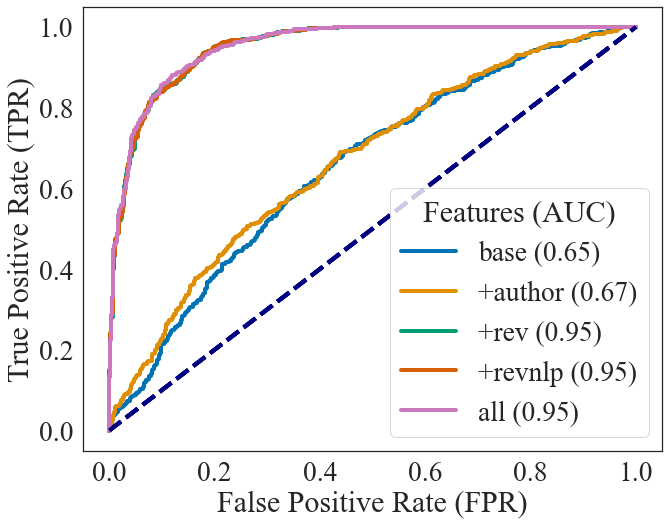

In [792]:

## prediction
for k,m in lg_models.items():
#     val_data = reg_data_val
    val_data =reg_data_val
    ylabel, ypred = val_data['binary_decision'], m.predict(val_data)
    auc = skm.roc_auc_score(ylabel, ypred)
    fpr,tpr,thres=skm.roc_curve(ylabel, ypred)
    acc = skm.accuracy_score(ylabel, ypred>0.5)
    
#     plt.plot(fpr,tpr,label=f"{k} (AUC: {auc:.2f}, ACC: {acc:.2f})")
    plt.plot(fpr,tpr,label=f"{k} ({auc:.2f})", lw=4)
    plt.plot([0, 1], [0, 1], color="navy", lw=4, linestyle="--")
plt.legend(loc=4, title='Features (AUC)')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")


plt.tight_layout()
plt.savefig('./figs/glm_roc_auc.png',bbox_inches='tight')
plt.savefig('./figs/glm_roc_auc.pdf',bbox_inches='tight')





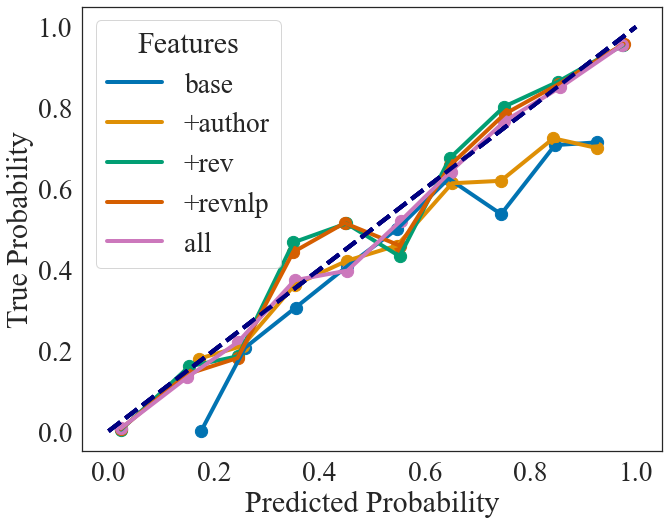

In [793]:

## calibration plot
for k,m in lg_models.items():
#     val_data = reg_data_val
    val_data =reg_data_val
    ylabel, ypred = val_data['binary_decision'], m.predict(val_data)
    prob_true, prob_pred = skc.calibration_curve(y_true=ylabel,
                  y_prob=ypred,n_bins=10,
    )
    auc = skm.roc_auc_score(ylabel, ypred)
    fpr,tpr,thres=skm.roc_curve(ylabel, ypred)
    acc = skm.accuracy_score(ylabel, ypred>0.5)
    
#     plt.plot(fpr,tpr,label=f"{k} (AUC: {auc:.2f}, ACC: {acc:.2f})")
    plt.scatter(prob_pred,prob_true, s=150)
    plt.plot(prob_pred,prob_true,label=f"{k}",lw=4)
    plt.plot([0, 1], [0, 1], color="navy", lw=4, linestyle="--")
plt.legend(loc=2, title='Features',ncol=1)
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.tight_layout()
plt.savefig('./figs/glm_calibration.png',bbox_inches='tight')
plt.savefig('./figs/glm_calibration.pdf',bbox_inches='tight')





In [794]:
import sklearn.calibration as skc

In [795]:
import sklearn.metrics as skm
import fairlearn
from fairlearn.metrics import MetricFrame, selection_rate
import fairlearn.metrics
# a convenience function that transforms the result of a group metric call into a data frame
def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})


In [796]:
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.xlabel(data.name)
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()
    
    
def get_max_disparity(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    return disparities[d_idx], xs[d_idx]
    

In [797]:
dfs = []
for att in ['demo_no_us','fst_perceived_f', 'any_perceived_f', 'top_author','top_inst']:
## calibration plot
    for k,m in lg_models.items():
        val_data = reg_data_val
        ylabel, ypred = val_data['binary_decision'], m.predict(val_data)
        A_test = val_data[att]

        dp=fairlearn.metrics.demographic_parity_difference(y_true=ylabel, y_pred=ypred>0.5, sensitive_features=A_test)
        eo=fairlearn.metrics.equalized_odds_difference(y_true=ylabel, y_pred=ypred>0.5, sensitive_features=A_test)
        
        scores_unmitigated = pd.Series(ypred, name="score_unmitigated")
        metric_frame_unmitigated = MetricFrame(metrics=skm.roc_auc_score,
                                           y_true=ylabel, y_pred=scores_unmitigated, sensitive_features=A_test)
        auc_unmitigated = summary_as_df("auc_unmitigated", metric_frame_unmitigated)
        max_d, max_loc = get_max_disparity(scores_unmitigated, A_test, loc=4)
        df = pd.DataFrame([[att, k, dp,eo, max_d]], columns=['att','feature','dp','eo','max_d'])
        dfs.append(df)
#     plot_and_compare_cdfs(scores_unmitigated, A_test, loc=4)
    



In [798]:
pd.concat(dfs)

,att,feature,dp,eo,max_d
0,demo_no_us,base,0.047215,0.063940,0.081543
0,demo_no_us,+author,0.116243,0.142119,0.121778
0,demo_no_us,+rev,0.049460,0.025077,0.068810
0,demo_no_us,+revnlp,0.051487,0.029429,0.068201
0,demo_no_us,all,0.046415,0.012423,0.072073
0,fst_perceived_f,base,0.026942,0.077027,0.063484
0,fst_perceived_f,+author,0.159163,0.168232,0.206558
0,fst_perceived_f,+rev,0.021985,0.107883,0.121072
0,fst_perceived_f,+revnlp,0.014459,0.087387,0.119195
0,fst_perceived_f,all,0.014459,0.077252,0.098676


In [357]:
lg_models['all'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_decision   No. Observations:                 5016
Model:                          Logit   Df Residuals:                     4986
Method:                           MLE   Df Model:                           29
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                  0.5962
Time:                        02:39:24   Log-Likelihood:                -1357.7
converged:                       True   LL-Null:                       -3362.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -28.8079      2.510    -11.476      0.000     -33.728     -23.888
arxiv_first[T.True]         0.3576      0.133      2.694      0.007       0.097       0.618
any_reported_f[T.True]      0.2238      0.297      0.755      0.450      -0.357       0.805
any_perceived_f[T.True]    -0.3726      0.322     -1.158      0.247      -1.003       0.258
np.log(input_len)           0.2624      0.146      1.799      0.072      -0.023       0.548
n_fig                       0.0112      0.008      1.349      0.177      -0.005       0.027
n_ref                       0.0090      0.003      2.682      0.007       0.002       0.016
n_sec                       0.0145      0.009      1.669      0.095      -0.003       0.032
sub_fluency                 9.2858      1.838      5.053      0.000       5.684      12.888
n_review                   -0.3751      0.113     -3.324      0.001      -0.596      -0.154
rating_max                 -0.4214      0.102     -4.118      0.000      -0.622      -0.221
rating_min                 -0.6044      0.090     -6.735      0.000      -0.780      -0.429
rating_avg                  4.2421      0.227     18.687      0.000       3.797       4.687
confidence_avg             -0.4760      0.237     -2.010      0.044      -0.940      -0.012
confidence_max              0.1842      0.132      1.396      0.163      -0.074       0.443
confidence_min             -0.0074      0.123     -0.060      0.952      -0.248       0.233
rlen_avg                   -0.0001      0.001     -0.126      0.899      -0.002       0.001
rlen_min                    0.0002      0.001      0.298      0.766      -0.001       0.001
rlen_max                 -6.92e-05      0.000     -0.223      0.823      -0.001       0.001
sentiment_avg              -0.1336      1.953     -0.068      0.945      -3.961       3.694
sentiment_min               1.2745      1.012      1.260      0.208      -0.708       3.257
sentiment_max               0.4815      0.973      0.495      0.621      -1.425       2.388
np.log(ins_rank_max)        0.6148      0.120      5.113      0.000       0.379       0.850
np.log(ins_rank_avg)       -0.5033      0.129     -3.913      0.000      -0.755      -0.251
np.log(author_cite_max)     0.1511      0.146      1.037      0.300      -0.134       0.437
np.log(author_cite_avg)    -0.1800      0.162     -1.109      0.267      -0.498       0.138
n_author                   -0.1101      0.033     -3.366      0.001      -0.174      -0.046
cnt_reported_f             -0.1756      0.235     -0.749      0.454      -0.635       0.284
cnt_perceived_f             0.2316      0.254      0.913      0.361      -0.266       0.729
np.log(primary_kwd_cnt)    -0.0147      0.030     -0.490      0.624      -0.073       0.044
===========================================================================================
"""